# References and variables

In [1]:
#import warnings
#warnings.filterwarnings('ignore')

import sys
sys.path.append('../fastai/old/') #fastai version 0.7

from fastai.conv_learner import *
from fastai.dataset import *
import fastai.transforms

import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import scipy.optimize as opt

from torchsummary import summary
from torchvision.models import *
from pathlib import Path

from functools import partial, update_wrapper

In [2]:
PATH = Path('/home/Deep_Learner/work/network/datasets/human-protein-atlas-image-classification/stage1_data')

TRAIN = PATH/'base_and_extra_data_pngs_512'
LABELS = PATH/'base_and_HPAv18RGBY_WithoutUncertain_wodpl.csv'
LABELS_EXTRA_ONLY = PATH/'HPAv18RGBY_WithoutUncertain_wodpl.csv'

TRAIN_NAMES_BASE = PATH/'tr_names(just_base).csv'
VAL_NAMES_BASE = PATH/'val_names(just_base).csv'

TEST = PATH/'test_pngs_512'
SAMPLE = PATH/'sample_submission.csv'

name_label_dict = {
0:  'Nucleoplasm',
1:  'Nuclear membrane',
2:  'Nucleoli',   
3:  'Nucleoli fibrillar center',
4:  'Nuclear speckles',
5:  'Nuclear bodies',
6:  'Endoplasmic reticulum',   
7:  'Golgi apparatus',
8:  'Peroxisomes',
9:  'Endosomes',
10:  'Lysosomes',
11:  'Intermediate filaments',
12:  'Actin filaments',
13:  'Focal adhesion sites',   
14:  'Microtubules',
15:  'Microtubule ends',  
16:  'Cytokinetic bridge',   
17:  'Mitotic spindle',
18:  'Microtubule organizing center',  
19:  'Centrosome',
20:  'Lipid droplets',
21:  'Plasma membrane',   
22:  'Cell junctions', 
23:  'Mitochondria',
24:  'Aggresome',
25:  'Cytosol',
26:  'Cytoplasmic bodies',   
27:  'Rods & rings' }

nw = 8   #number of workers for data loader
torch.cuda.set_device(0)
torch.backends.cudnn.benchmark=True
np.random.seed(42)

# Data

In [3]:
def remove_suffix(s:str):
    """
    Removes the '_red', '_green', '_blue', '_yellow' suffix and everything coming afterwards from the filename
    """
    suffixes = ['_red', '_green', '_blue', '_yellow']
    for suf in suffixes:
        if suf in s:
            return s[:s.find(suf)]
        else:
            continue            

In [4]:
tr_n = list(pd.read_csv(TRAIN_NAMES_BASE).Id)
val_n = list(pd.read_csv(VAL_NAMES_BASE).Id)

#extra_data ids
ids_extra = list(set(pd.read_csv(LABELS_EXTRA_ONLY).Id))

In [5]:
#for i in tqdm(ids_extra):
#    open_rgby(TRAIN, i)

In [6]:
broken_ids =    ['35812_1303_F4_4',
                '21777_146_F12_2',
                '48464_824_C4_3',
                '61917_1276_B12_1',
                '21213_si24_C7_8',
                '6518_1601_A3_2',
                '27425_218_D9_2',
                '13432_104_G6_1',
                '62743_1246_E5_2',
                '58495_1336_H3_3',
                '64401_1193_D10_1',
                '15331_932_C2_2',
                '36287_1042_G10_3',
                '37528_448_A11_2',
                '19728_209_H9_1']

for i in broken_ids:
    try:
        ids_extra.remove(i)
    except:
        print(i)

In [7]:
t, v = train_test_split(ids_extra, test_size=0.2, random_state=42)
for i in t:
    tr_n.append(i)
for i in v:
    val_n.append(i)
    
test_names = list({remove_suffix(f) for f in os.listdir(TEST)})

In [8]:
print(len(tr_n))
print(len(tr_n)+len(val_n))
print(len(pd.read_csv(LABELS).Id) - len(broken_ids))

85712
102494
102494


In [9]:
#creating duplicates for rare classes in train set
class Oversampling:
    def __init__(self,path):
        self.train_labels = pd.read_csv(path).set_index('Id')
        self.train_labels['Target'] = [[int(i) for i in s.split()] 
                                       for s in self.train_labels['Target']]  
        #set the minimum number of duplicates for each class
        #self.multi = [1,1,1,1,1,1,1,1,4,4,4,1,1,1,1,4,1,1,1,1,2,1,1,1,1,1,1,4]
        self.multi = [1,1,1,1,1,1,1,1,2,2,3,1,1,1,1,5,1,1,1,1,1,1,1,1,1,1,1,4]
    def get(self,image_id):
        labels = self.train_labels.loc[image_id,'Target'] if image_id \
          in self.train_labels.index else []
        m = 1
        for l in labels:
            if m < self.multi[l]: m = self.multi[l]
        return m
    
s = Oversampling(LABELS)
tr_n = [idx for idx in tr_n for _ in range(s.get(idx))]
print(len(tr_n),flush=True)

86714


In [10]:
def open_rgby(path,id): #a function that reads RGBY image
    try:
        colors = ['red','green','blue','yellow']
        flags = cv2.IMREAD_GRAYSCALE
        img = [cv2.imread(os.path.join(path, id+'_'+color+'.png'), flags).astype(np.float32)/255
               for color in colors]
        return np.stack(img, axis=-1)
    except:
        print(id)

class pdFilesDataset(FilesDataset):
    def __init__(self, fnames, path, transform):
        self.labels = pd.read_csv(LABELS).set_index('Id')
        self.labels['Target'] = [[int(i) for i in s.split()] for s in self.labels['Target']]
        super().__init__(fnames, transform, path)
    
    def get_x(self, i):
        img = open_rgby(self.path,self.fnames[i])
        if self.sz == 512: return img 
        else: return cv2.resize(img, (self.sz, self.sz),cv2.INTER_AREA)
    
    def get_y(self, i):
        if(self.path == TEST): return np.zeros(len(name_label_dict),dtype=np.int)
        else:
            labels = self.labels.loc[self.fnames[i]]['Target']
            return np.eye(len(name_label_dict),dtype=np.float)[labels].sum(axis=0)
        
    @property
    def is_multi(self): return True
    @property
    def is_reg(self):return True
    #this flag is set to remove the output sigmoid that allows log(sigmoid) optimization
    #of the numerical stability of the loss function
    
    def get_c(self): return len(name_label_dict) #number of classes
    

def get_data(sz,bs,is_test=False):
    #data augmentation
    if is_test:
        aug_tfms = [RandomRotate(30, tfm_y=TfmType.NO),
                    RandomDihedral(tfm_y=TfmType.NO)]
    else:
        aug_tfms = [RandomRotate(30, tfm_y=TfmType.NO),
                    RandomDihedral(tfm_y=TfmType.NO),
                    RandomLighting(0.05, 0.05, tfm_y=TfmType.NO)]
                    #Cutout(n_holes=25, length=10*sz//128, tfm_y=TfmType.NO)]
    #mean and std in of each channel in the train set
    #stats = A([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])
    #stats = A([0.07769, 0.0538 , 0.05758, 0.08284], [0.12122, 0.0921 , 0.1372 , 0.12723])
    #image-net stats:
    imagenet_stats = ([0.485, 0.456, 0.406, 0.485], [0.229, 0.224, 0.225, 0.229])
      
    tfms = tfms_from_stats(imagenet_stats, sz, crop_type=CropType.NO, tfm_y=TfmType.NO, 
                aug_tfms=aug_tfms)
    ds = ImageData.get_ds(pdFilesDataset, (tr_n[:-(len(tr_n)%bs)],TRAIN), 
                (val_n,TRAIN), tfms, test=(test_names,TEST))
       
    md = ImageData(PATH, ds, bs, num_workers=nw, classes=None)
    return md

Plot several examples of input images.

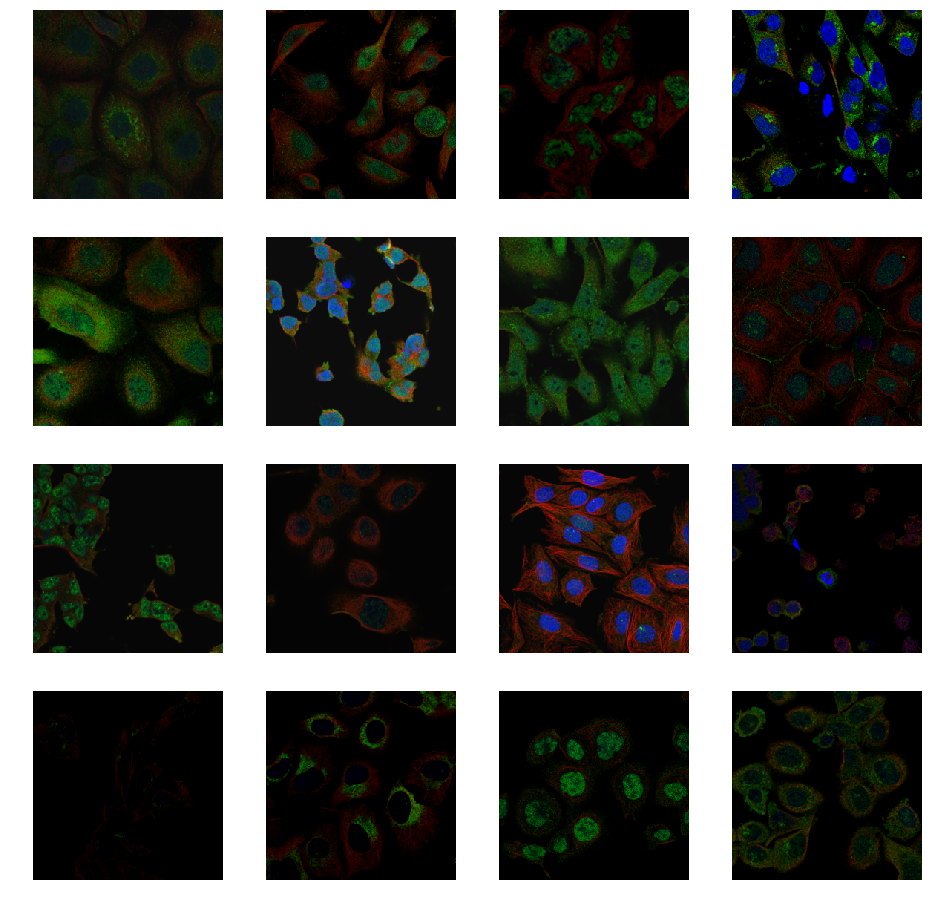

In [11]:
sz = 256
bs =16

md = get_data(sz,bs)

x,y = next(iter(md.trn_dl))
x.shape, y.shape

def display_imgs(x):
    columns = 4
    bs = x.shape[0]
    rows = min((bs+3)//4,4)
    fig=plt.figure(figsize=(columns*4, rows*4))
    for i in range(rows):
        for j in range(columns):
            idx = i+j*columns
            fig.add_subplot(rows, columns, idx+1)
            plt.axis('off')
            plt.imshow((x[idx,:,:,:3]*255).astype(np.int))
    plt.show()
    
display_imgs(np.asarray(md.trn_ds.denorm(x)))

# Computing image statistics in the train set for normalization

In [12]:
#x_tot = np.zeros(4)
#x2_tot = np.zeros(4)
#for x,y in iter(md.trn_dl):
#    try:
#        x = md.trn_ds.denorm(x).reshape(-1,4)
#        x_tot += x.mean(axis=0)
#        x2_tot += (x**2).mean(axis=0)
#    except:
#        print('broke')
#
#channel_avr = x_tot/len(md.trn_dl)
#channel_std = np.sqrt(x2_tot/len(md.trn_dl) - channel_avr**2)
#channel_avr,channel_std

# Loss function and metrics

In [11]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum(dim=1).mean()
    
def acc(preds,targs,th=0.0):
    preds = (preds > th).int()
    targs = targs.int()
    return (preds==targs).float().mean()

def fbeta(y_pred:torch.Tensor, y_true:torch.Tensor, thresh:float=0.2, beta:float=2, eps:float=1e-9, sigmoid:bool=True) -> torch.Tensor:
    "Computes the f_beta between `y_pred` and `y_true` in a multi-classification task."
    beta2 = beta**2
    if sigmoid: y_pred = y_pred.sigmoid()
    y_pred = (y_pred>thresh).float()
    y_true = y_true.float()
    TP = (y_pred*y_true).sum(dim=1)
    prec = TP/(y_pred.sum(dim=1)+eps)
    rec = TP/(y_true.sum(dim=1)+eps)
    res = (prec*rec)/(prec*beta2+rec+eps)*(1+beta2)
    return res.mean()

def wrapped_partial(func, *args, **kwargs):
    partial_func = partial(func, *args, **kwargs)
    update_wrapper(partial_func, func)
    return partial_func

f1_score_fastai = wrapped_partial(fbeta, thresh=0.5, beta=1)

# Custom ConvnetBuilder

In [12]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
#model = torchvision.models.inception_v3(True).to(device)
#summary(model, (3, 299, 299))
#
#ar = inception_v3(True)
#
#ar.Conv2d_1a_3x3.conv
#
#layers_test = cut_model(ar, -1)
#
#layers_test[0].conv
#
#layers_test[0].conv

In [13]:
class ConvnetBuilder_custom():
    def __init__(self, f, c, is_multi, is_reg, ps=None, xtra_fc=None, xtra_cut=0, 
                 custom_head=None, pretrained=True):
        self.f,self.c,self.is_multi,self.is_reg,self.xtra_cut = f,c,is_multi,is_reg,xtra_cut
        if xtra_fc is None: xtra_fc = [512]
        if ps is None: ps = [0.25]*len(xtra_fc) + [0.5]
        self.ps,self.xtra_fc = ps,xtra_fc

        if f in model_meta: cut,self.lr_cut = model_meta[f]
        else: cut,self.lr_cut = 0,0
        cut-=xtra_cut
        layers = cut_model(f(pretrained), cut)
        
        #replace first convolutional layer by 4->64 while keeping corresponding weights
        #and initializing new weights with channel 1 weights
        if f in [inception_4]:
            w = layers[0].conv.weight
            layers[0].conv = nn.Conv2d(4, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
            layers[0].conv.weight = torch.nn.Parameter(torch.cat((w,w[:,:1,:,:]),dim=1))
                          
        if f in [inception_v3]:
            #w = layers[0].Conv2d_1a_3x3.conv.weight
            #layers[0].Conv2d_1a_3x3.conv = nn.Conv2d(4, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
            #layers[0].Conv2d_1a_3x3.conv.weight = torch.nn.Parameter(torch.cat((w,w[:,:1,:,:]),dim=1))
            w = layers[0].conv.weight
            layers[0].conv = nn.Conv2d(4, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
            layers[0].conv.weight = torch.nn.Parameter(torch.cat((w,w[:,:1,:,:]),dim=1))
            
        if f in [resnet18, resnet34, resnet50, resnet101, resnet152]:
            w = layers[0].weight
            layers[0] = nn.Conv2d(4,64,kernel_size=(7,7),stride=(2,2),padding=(3, 3), bias=False)
            #layers[0].weight = torch.nn.Parameter(torch.cat((w,torch.zeros(64,1,7,7)),dim=1)) #init with zeros
            layers[0].weight = torch.nn.Parameter(torch.cat((w,w[:,:1,:,:]),dim=1)) # init with weights of 1st channel

        #else:
            #raise ValueError('Function f for creating the model not supported!')
        
        self.nf = model_features[f] if f in model_features else (num_features(layers)*2)
        if not custom_head: layers += [AdaptiveConcatPool2d(), Flatten()]
        self.top_model = nn.Sequential(*layers)

        n_fc = len(self.xtra_fc)+1
        if not isinstance(self.ps, list): self.ps = [self.ps]*n_fc

        if custom_head: fc_layers = [custom_head]
        else: fc_layers = self.get_fc_layers()
        self.n_fc = len(fc_layers)
        self.fc_model = to_gpu(nn.Sequential(*fc_layers))
        if not custom_head: apply_init(self.fc_model, kaiming_normal)
        self.model = to_gpu(nn.Sequential(*(layers+fc_layers)))

    @property
    def name(self): return f'{self.f.__name__}_{self.xtra_cut}'

    def create_fc_layer(self, ni, nf, p, actn=None):
        res=[nn.BatchNorm1d(num_features=ni)]
        if p: res.append(nn.Dropout(p=p))
        res.append(nn.Linear(in_features=ni, out_features=nf))
        if actn: res.append(actn)
        return res

    def get_fc_layers(self):
        res=[]
        ni=self.nf
        for i,nf in enumerate(self.xtra_fc):
            res += self.create_fc_layer(ni, nf, p=self.ps[i], actn=nn.ReLU())
            ni=nf
        final_actn = nn.Sigmoid() if self.is_multi else nn.LogSoftmax()
        if self.is_reg: final_actn = None
        res += self.create_fc_layer(ni, self.c, p=self.ps[-1], actn=final_actn)
        return res

    def get_layer_groups(self, do_fc=False):
        if do_fc:
            return [self.fc_model]
        idxs = [self.lr_cut]
        c = children(self.top_model)
        if len(c)==3: c = children(c[0])+c[1:]
        lgs = list(split_by_idxs(c,idxs))
        return lgs+[self.fc_model]
    
class ConvLearner(Learner):
    def __init__(self, data, models, precompute=False, **kwargs):
        self.precompute = False
        super().__init__(data, models, **kwargs)
        if hasattr(data, 'is_multi') and not data.is_reg and self.metrics is None:
            self.metrics = [accuracy_thresh(0.5)] if self.data.is_multi else [accuracy]
        if precompute: self.save_fc1()
        self.freeze()
        self.precompute = precompute

    def _get_crit(self, data):
        if not hasattr(data, 'is_multi'): return super()._get_crit(data)

        return F.l1_loss if data.is_reg else F.binary_cross_entropy if data.is_multi else F.nll_loss

    @classmethod
    def pretrained(cls, f, data, ps=None, xtra_fc=None, xtra_cut=0, custom_head=None, precompute=False,
                   pretrained=True, **kwargs):
        models = ConvnetBuilder_custom(f, data.c, data.is_multi, data.is_reg,
            ps=ps, xtra_fc=xtra_fc, xtra_cut=xtra_cut, custom_head=custom_head, pretrained=pretrained)
        return cls(data, models, precompute, **kwargs)

    @classmethod
    def lsuv_learner(cls, f, data, ps=None, xtra_fc=None, xtra_cut=0, custom_head=None, precompute=False,
                  needed_std=1.0, std_tol=0.1, max_attempts=10, do_orthonorm=False, **kwargs):
        models = ConvnetBuilder(f, data.c, data.is_multi, data.is_reg,
            ps=ps, xtra_fc=xtra_fc, xtra_cut=xtra_cut, custom_head=custom_head, pretrained=False)
        convlearn=cls(data, models, precompute, **kwargs)
        convlearn.lsuv_init()
        return convlearn
    
    @property
    def model(self): return self.models.fc_model if self.precompute else self.models.model
    
    def half(self):
        if self.fp16: return
        self.fp16 = True
        if type(self.model) != FP16: self.models.model = FP16(self.model)
        if not isinstance(self.models.fc_model, FP16): self.models.fc_model = FP16(self.models.fc_model)
    def float(self):
        if not self.fp16: return
        self.fp16 = False
        if type(self.models.model) == FP16: self.models.model = self.model.module.float()
        if type(self.models.fc_model) == FP16: self.models.fc_model = self.models.fc_model.module.float()

    @property
    def data(self): return self.fc_data if self.precompute else self.data_

    def create_empty_bcolz(self, n, name):
        return bcolz.carray(np.zeros((0,n), np.float32), chunklen=1, mode='w', rootdir=name)

    def set_data(self, data, precompute=False):
        super().set_data(data)
        if precompute:
            self.unfreeze()
            self.save_fc1()
            self.freeze()
            self.precompute = True
        else:
            self.freeze()

    def get_layer_groups(self):
        return self.models.get_layer_groups(self.precompute)

    def summary(self):
        precompute = self.precompute
        self.precompute = False
        res = super().summary()
        self.precompute = precompute
        return res

    def get_activations(self, force=False):
        tmpl = f'_{self.models.name}_{self.data.sz}.bc'
        # TODO: Somehow check that directory names haven't changed (e.g. added test set)
        names = [os.path.join(self.tmp_path, p+tmpl) for p in ('x_act', 'x_act_val', 'x_act_test')]
        if os.path.exists(names[0]) and not force:
            self.activations = [bcolz.open(p) for p in names]
        else:
            self.activations = [self.create_empty_bcolz(self.models.nf,n) for n in names]

    def save_fc1(self):
        self.get_activations()
        act, val_act, test_act = self.activations
        m=self.models.top_model
        if len(self.activations[0])!=len(self.data.trn_ds):
            predict_to_bcolz(m, self.data.fix_dl, act)
        if len(self.activations[1])!=len(self.data.val_ds):
            predict_to_bcolz(m, self.data.val_dl, val_act)
        if self.data.test_dl and (len(self.activations[2])!=len(self.data.test_ds)):
            if self.data.test_dl: predict_to_bcolz(m, self.data.test_dl, test_act)

        self.fc_data = ImageClassifierData.from_arrays(self.data.path,
                (act, self.data.trn_y), (val_act, self.data.val_y), self.data.bs, classes=self.data.classes,
                test = test_act if self.data.test_dl else None, num_workers=8)

    def freeze(self):
        self.freeze_to(-1)

    def unfreeze(self):
        self.freeze_to(0)
        self.precompute = False

    def predict_array(self, arr):
        precompute = self.precompute
        self.precompute = False
        pred = super().predict_array(arr)
        self.precompute = precompute
        return pred
    
        
    def lr_find_custom(self, tmpName:str, start_lr=1e-5, end_lr=10, wds=None, linear=False, **kwargs):
        """
        Custom: lets you specify the name of the temporary .h5 file
        
        Helps you find an optimal learning rate for a model.

         It uses the technique developed in the 2015 paper
         `Cyclical Learning Rates for Training Neural Networks`, where
         we simply keep increasing the learning rate from a very small value,
         until the loss starts decreasing.

        Args:
            start_lr (float/numpy array) : Passing in a numpy array allows you
                to specify learning rates for a learner's layer_groups
            end_lr (float) : The maximum learning rate to try.
            wds (iterable/float)

        Examples:
            As training moves us closer to the optimal weights for a model,
            the optimal learning rate will be smaller. We can take advantage of
            that knowledge and provide lr_find() with a starting learning rate
            1000x smaller than the model's current learning rate as such:

            >> learn.lr_find(lr/1000)

            >> lrs = np.array([ 1e-4, 1e-3, 1e-2 ])
            >> learn.lr_find(lrs / 1000)

        Notes:
            lr_find() may finish before going through each batch of examples if
            the loss decreases enough.

        .. _Cyclical Learning Rates for Training Neural Networks:
            http://arxiv.org/abs/1506.01186

        """
        self.save(tmpName)
        layer_opt = self.get_layer_opt(start_lr, wds)
        self.sched = LR_Finder(layer_opt, len(self.data.trn_dl), end_lr, linear=linear)
        self.fit_gen(self.model, self.data, layer_opt, 1, **kwargs)
        self.load(tmpName)

# Training

## resnet34

In [14]:
arch = resnet34

### size 128

#### size 128 b

In [15]:
sz = 128 #image size
bs = 64 #batch size
md = get_data(sz,bs)
if(arch in [inception_v3]):
    learner = ConvLearner.pretrained(arch, md, ps=0.5, xtra_cut=1) #dropout 50%
else:
    learner = ConvLearner.pretrained(arch, md, ps=0.5, xtra_cut=0) #dropout 50%
learner.opt_fn = optim.Adam
learner.clip = 1.0 #gradient clipping
learner.crit = FocalLoss()
learner.metrics = [acc, f1_score_fastai]
learner.summary

<bound method ConvLearner.summary of Sequential(
  (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inpla

In [17]:
#import warnings
#warnings.filterwarnings('ignore')

 71%|███████▏  | 996/1394 [07:38<04:04,  1.63it/s, loss=5.25]

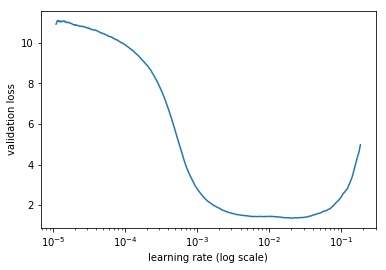

In [18]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.lr_find()
learner.sched.plot()

First, I train only the head of the model while keeping the rest frozen. It allows to avoid corruption of the pretrained weights at the initial stage of training due to random initialization of the head layers. So the power of transfer learning is fully utilized when the training is continued.

In [16]:
lr = 6e-4
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.fit(lr, 2, cycle_len=1, use_clr=(10,10))

epoch      trn_loss   val_loss   acc        fbeta             
    0      1.242813   1.17263    0.949588   0.252761  
    1      1.195865   1.154853   0.94976    0.24407           



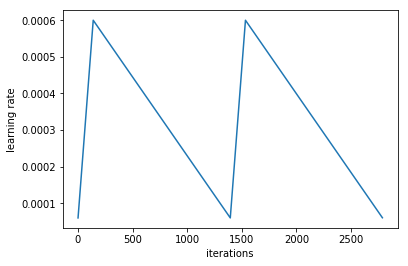

In [17]:
learner.sched.plot_lr()

In [18]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.fit(lr, 2, cycle_len=1, use_clr=(10,10))

epoch      trn_loss   val_loss   acc        fbeta             
    0      1.171174   1.149039   0.950135   0.266623  
    1      1.177326   1.145919   0.950191   0.25992           



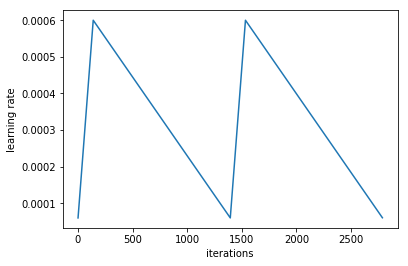

In [19]:
learner.sched.plot_lr()

In [20]:
learner.unfreeze()
lrs=np.array([lr/10,lr/3,lr])

In [21]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.fit(lrs,4,cycle_len=2,use_clr=(10,10))

epoch      trn_loss   val_loss   acc        fbeta             
    0      1.005564   0.976978   0.95751    0.465318  
    1      0.943499   0.915755   0.960393   0.514737           
    2      0.93856    0.909035   0.960812   0.507342           
    3      0.894399   0.87423    0.96213    0.545516           
    4      0.90134    0.879642   0.961895   0.532506           
    5      0.86818    0.844339   0.96334    0.565347           
    6      0.864616   0.862028   0.962356   0.556363           
    7      0.823117   0.829964   0.964054   0.586022           



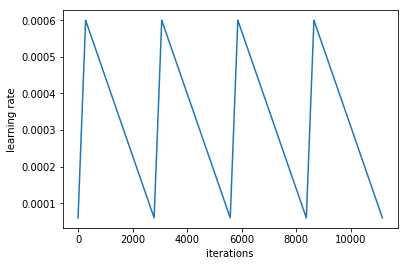

In [22]:
learner.sched.plot_lr()

In [23]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.fit(lrs,4,cycle_len=2,use_clr=(10,10))

epoch      trn_loss   val_loss   acc        fbeta              
    0      0.851964   0.850441   0.96294    0.574474  
    1      0.810052   0.814738   0.964569   0.59413            
    2      0.816809   0.835869   0.963449   0.583928           
    3      0.800623   0.809283   0.964788   0.602057           
    4      0.826727   0.836221   0.963429   0.572756           
    5      0.760979   0.797353   0.965233   0.603535           
    6      0.787124   0.826801   0.964089   0.585408           
    7      0.745338   0.793374   0.965352   0.617602           



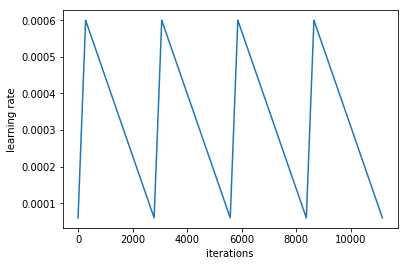

In [24]:
learner.sched.plot_lr()

In [25]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.fit(lrs/4,2,cycle_len=4,use_clr=(10,10))

epoch      trn_loss   val_loss   acc        fbeta              
    0      0.746322   0.796639   0.96533    0.617531  
    1      0.715788   0.791038   0.96558    0.618162           
    2      0.712953   0.788923   0.965654   0.622067           
    3      0.696787   0.78628    0.965732   0.618232           
    4      0.707857   0.797479   0.965313   0.61402            
    5      0.692189   0.789184   0.965399   0.616426           
    6      0.686555   0.788919   0.965779   0.625132           
    7      0.680105   0.788077   0.965779   0.623166           



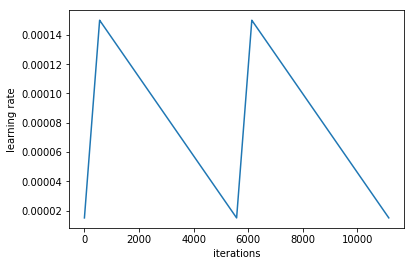

In [26]:
learner.sched.plot_lr()

In [27]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.fit(lrs/8,1,cycle_len=8,use_clr=(10,10))

epoch      trn_loss   val_loss   acc        fbeta              
    0      0.675778   0.795616   0.965502   0.622808  
    1      0.678493   0.796928   0.965393   0.622967           
    2      0.689949   0.793096   0.965777   0.624863           
    3      0.668055   0.792882   0.965916   0.626791           
    4      0.653534   0.791452   0.965822   0.625594           
    5      0.659496   0.793576   0.965748   0.628518           
    6      0.642513   0.795581   0.965719   0.629262           
    7      0.640456   0.796631   0.965707   0.628943           



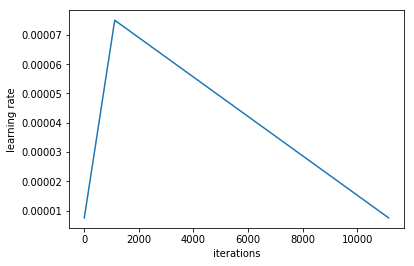

In [28]:
learner.sched.plot_lr()

In [29]:
name = 'resnet34-b'

In [30]:
learner.save(name)

#### size 128 c

In [17]:
sz = 128 #image size
bs = 64 #batch size
md = get_data(sz,bs)
if(arch in [inception_v3]):
    learner = ConvLearner.pretrained(arch, md, ps=0.5, xtra_cut=1) #dropout 50%
else:
    learner = ConvLearner.pretrained(arch, md, ps=0.5, xtra_cut=0) #dropout 50%
learner.opt_fn = optim.Adam
learner.clip = 1.0 #gradient clipping
learner.crit = FocalLoss()
learner.metrics = [acc, f1_score_fastai]

 71%|███████   | 988/1393 [02:44<01:12,  5.56it/s, loss=5.25]

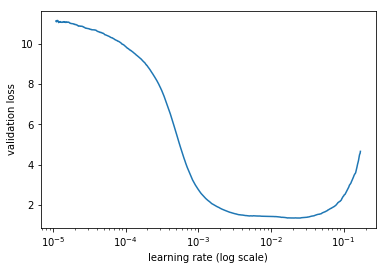

In [19]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.lr_find()
learner.sched.plot()

In [18]:
lr = 6e-4

In [19]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.fit(lr, 1, cycle_len=5, use_clr=(10,10))

epoch      trn_loss   val_loss   acc        fbeta             
    0      1.23751    1.172891   0.949151   0.23255   
    1      1.196196   1.153913   0.949846   0.248169          
    2      1.181914   1.146994   0.950219   0.281725          
    3      1.16231    1.14405    0.950263   0.273172          
    4      1.163927   1.140041   0.950425   0.274677          



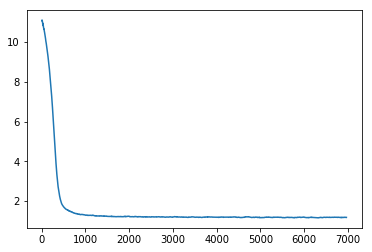

In [20]:
learner.sched.plot_loss()

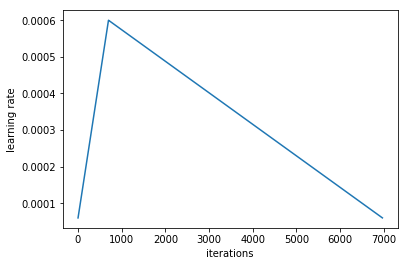

In [21]:
learner.sched.plot_lr()

In [22]:
learner.save('resnet34-c1')

In [36]:
learner.load('resnet34-c1')

In [37]:
learner.unfreeze()

 68%|██████▊   | 948/1394 [03:08<01:15,  5.89it/s, loss=4.45]

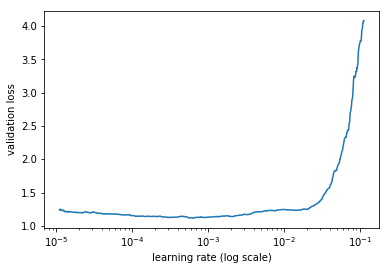

In [25]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.lr_find()
learner.sched.plot()

In [38]:
lrs=np.array([1e-5,lr/10,lr/5])

In [39]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.fit(lrs,1,cycle_len=8,use_clr=(10,10))

epoch      trn_loss   val_loss   acc        fbeta             
    0      1.082176   1.040124   0.95508    0.392232  
    1      1.019345   0.985269   0.957358   0.452643          
    2      0.98115    0.951652   0.958831   0.483244           
    3      0.959484   0.933846   0.95953    0.48668            
    4      0.948196   0.923179   0.959881   0.505414           
    5      0.938135   0.914505   0.96018    0.511559           
    6      0.926404   0.906145   0.960441   0.515872           
    7      0.89178    0.899813   0.960797   0.518246           


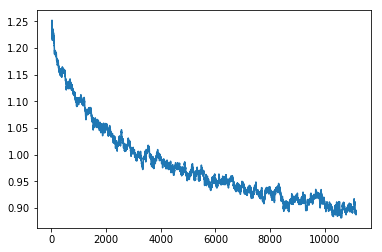

In [40]:
learner.sched.plot_loss()

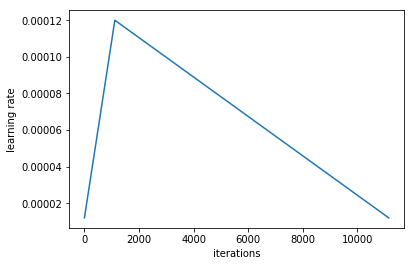

In [41]:
learner.sched.plot_lr()

In [42]:
learner.save('resnet34-c2')

In [44]:
learner.load('resnet34-c2')

In [45]:
lrs=np.array([1e-5,lr/3,lr])

In [46]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.fit(lrs,1,cycle_len=12,use_clr=(10,10))

epoch      trn_loss   val_loss   acc        fbeta              
    0      0.952281   0.943096   0.958753   0.507391  
    1      0.959596   0.93569    0.959444   0.480049           
    2      0.933449   0.914842   0.960367   0.508474           
    3      0.903464   0.905528   0.960414   0.516755           
    4      0.884019   0.88688    0.961318   0.532541           
    5      0.880182   0.878525   0.961726   0.539345           
    6      0.854272   0.874526   0.961706   0.534215           
    7      0.839335   0.862312   0.962223   0.55925            
    8      0.814028   0.858122   0.962534   0.557152           
    9      0.809326   0.853703   0.962703   0.563211           
    10     0.78169    0.849665   0.962975   0.570074           
    11     0.768702   0.846234   0.963184   0.574225           


In [47]:
learner.save('resnet34-c3')

#### size 128 d (best one)

In [ ]:
sz = 128 #image size
bs = 64 #batch size
md = get_data(sz,bs)
if(arch in [inception_v3]):
    learner = ConvLearner.pretrained(arch, md, ps=0.5, xtra_cut=1) #dropout 50%
else:
    learner = ConvLearner.pretrained(arch, md, ps=0.5, xtra_cut=0) #dropout 50%
learner.opt_fn = optim.Adam
learner.clip = 1.0 #gradient clipping
learner.crit = FocalLoss()
learner.metrics = [acc, f1_score_fastai]

 72%|███████▏  | 971/1355 [02:41<01:35,  4.01it/s, loss=5.45]

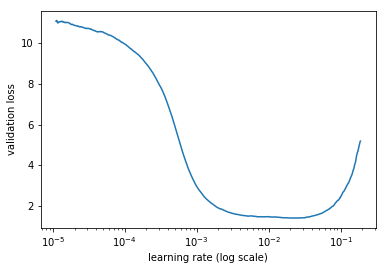

In [18]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.lr_find()
learner.sched.plot()

In [19]:
lr = 1e-3

In [20]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.fit(lr, 1, cycle_len=8, use_clr=(10,10))

epoch      trn_loss   val_loss   acc        fbeta             
    0      1.246329   1.182332   0.94917    0.24533   
    1      1.209549   1.161686   0.949519   0.249436          
    2      1.177272   1.154381   0.949968   0.255041          
    3      1.173988   1.149534   0.950012   0.266075          
    4      1.147982   1.14842    0.950215   0.285051          
    5      1.174586   1.143052   0.950202   0.255145          
    6      1.159381   1.142312   0.950357   0.268812          
    7      1.16024    1.139997   0.950338   0.270745          


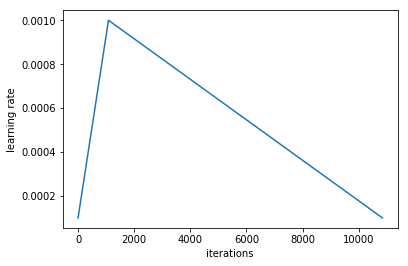

In [21]:
learner.sched.plot_lr()

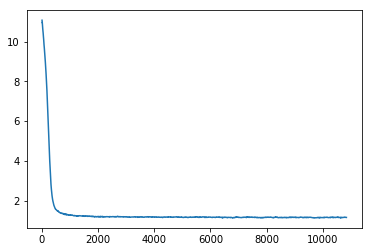

In [22]:
learner.sched.plot_loss()

In [23]:
learner.save('resnet34-d1')

In [60]:
learner.load('resnet34-d1')

In [24]:
learner.unfreeze()

 69%|██████▉   | 932/1355 [07:16<02:50,  2.48it/s, loss=4.35]

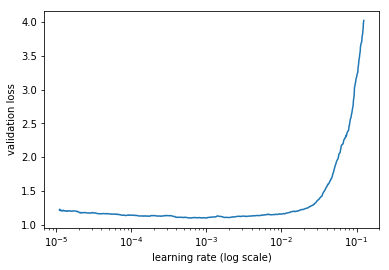

In [25]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.lr_find()
learner.sched.plot()

In [26]:
lrs=np.array([1e-4,lr/5,lr/3])

In [27]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.fit(lrs,1,cycle_len=20,use_clr=(20,10))

epoch      trn_loss   val_loss   acc        fbeta             
    0      1.035009   1.015801   0.956486   0.415298  
    1      0.982034   0.958103   0.958946   0.498874           
    2      0.921497   0.918479   0.960408   0.526764           
    3      0.874901   0.888569   0.961685   0.531442           
    4      0.878915   0.900556   0.960859   0.533239           
    5      0.857601   0.866571   0.962856   0.559031           
    6      0.848352   0.845415   0.963294   0.56462            
    7      0.835921   0.822209   0.964433   0.587              
    8      0.818796   0.825808   0.964586   0.593571           
    9      0.794026   0.809004   0.965043   0.590719           
    10     0.783074   0.809015   0.964841   0.60916            
    11     0.763922   0.797883   0.965529   0.616488           
    12     0.76371    0.790131   0.965582   0.627267           
    13     0.73891    0.802821   0.965192   0.613125           
    14     0.729532   0.773714   0.966444   0.6309

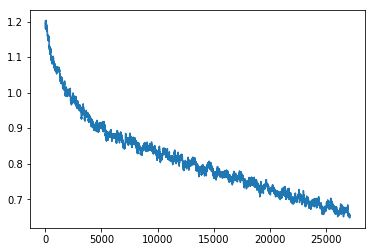

In [28]:
learner.sched.plot_loss()

In [29]:
learner.save('resnet34-d2')

#### size 128 e

In [66]:
sz = 128 #image size
bs = 64 #batch size
md = get_data(sz,bs)
if(arch in [inception_v3]):
    learner = ConvLearner.pretrained(arch, md, ps=0.5, xtra_cut=1) #dropout 50%
else:
    learner = ConvLearner.pretrained(arch, md, ps=0.5, xtra_cut=0) #dropout 50%
learner.opt_fn = optim.Adam
learner.clip = 1.0 #gradient clipping
learner.crit = FocalLoss()
learner.metrics = [acc, f1_score_fastai]

 71%|███████   | 990/1394 [02:43<00:58,  6.87it/s, loss=5.53]

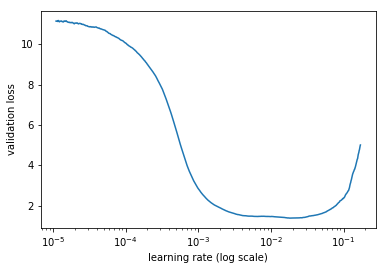

In [67]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.lr_find()
learner.sched.plot()

In [68]:
lr = 1e-3

In [69]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.fit(lr, 1, cycle_len=10, use_clr=(20,10))

epoch      trn_loss   val_loss   acc        fbeta             
    0      1.239479   1.184968   0.949053   0.232396  
    1      1.172649   1.157225   0.949705   0.237091          
    2      1.170276   1.14922    0.950197   0.272309          
    3      1.17339    1.141708   0.950275   0.252951          
    4      1.159332   1.140022   0.950375   0.274308          
    5      1.157771   1.138617   0.950437   0.26983           
    6      1.162912   1.136446   0.95065    0.266644          
    7      1.159868   1.134942   0.950644   0.278811          
    8      1.153916   1.132492   0.950626   0.270803          
    9      1.147045   1.132437   0.950662   0.275322          


In [70]:
learner.save('resnet34-e1')

In [71]:
learner.unfreeze()

 68%|██████▊   | 948/1394 [03:10<01:30,  4.93it/s, loss=4.34]

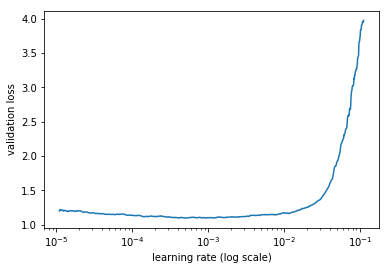

In [72]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.lr_find()
learner.sched.plot()

In [73]:
lrs=np.array([1e-4,lr/5,lr/3])

In [74]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.fit(lrs,1,cycle_len=30,use_clr=(40,10))

epoch      trn_loss   val_loss   acc        fbeta             
    0      1.054762   1.028982   0.955443   0.426987  
    1      0.99385    0.968369   0.958279   0.460906           
    2      0.950958   0.946207   0.959364   0.495473           
    3      0.920949   0.886084   0.961476   0.531177           
    4      0.888175   0.929265   0.959132   0.489494           
    5      0.873882   1.048417   0.952252   0.439206           
    6      0.840227   0.837635   0.963603   0.576085           
    7      0.834747   0.839673   0.963435   0.581593           
    8      0.824434   0.835667   0.963619   0.578845           
    9      0.804427   0.818755   0.964476   0.58569            
    10     0.787939   0.841942   0.963416   0.56878            
    11     0.77268    0.812176   0.964723   0.595308           
    12     0.772857   0.80079    0.965155   0.602881           
    13     0.762461   0.797168   0.96536    0.61552            
    14     0.744044   0.812946   0.964429   0.6071

In [75]:
learner.save('resnet34-e2')

In [ ]:
0.668382   0.768761   0.966825   0.639705   

In [30]:
sz = 256 #image size
bs = 64 #batch size
md = get_data(sz,bs)
if(arch in [inception_v3]):
    learner = ConvLearner.pretrained(arch, md, ps=0.5, xtra_cut=1) #dropout 50%
else:
    learner = ConvLearner.pretrained(arch, md, ps=0.5, xtra_cut=0) #dropout 50%
learner.opt_fn = optim.Adam
learner.clip = 1.0 #gradient clipping
learner.crit = FocalLoss()
learner.metrics = [acc, f1_score_fastai]

In [31]:
learner.load('resnet34-d2')

 71%|███████▏  | 967/1355 [23:42<04:58,  1.30it/s, loss=4.54]  

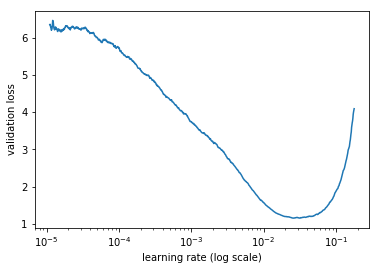

In [33]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.lr_find()
learner.sched.plot()

In [34]:
lr = 1e-3

### size 512

In [15]:
sz = 512 #image size
bs = 32 #batch size
md = get_data(sz,bs)
if(arch in [inception_v3]):
    learner = ConvLearner.pretrained(arch, md, ps=0.5, xtra_cut=1) #dropout 50%
else:
    learner = ConvLearner.pretrained(arch, md, ps=0.5, xtra_cut=0) #dropout 50%
learner.opt_fn = optim.Adam
learner.clip = 1.0 #gradient clipping
learner.crit = FocalLoss()
learner.metrics = [acc, f1_score_fastai]

 68%|██████▊   | 1843/2708 [25:47<21:02,  1.46s/it, loss=5.26]  

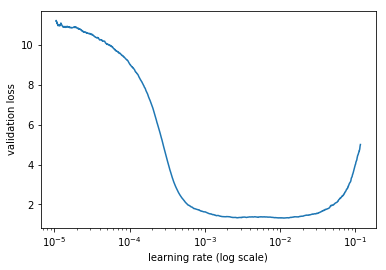

In [17]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.lr_find_custom(tmpName=f'tmp_{arch.__name__}')
learner.sched.plot()

In [ ]:
lr = 5e-4

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.fit(lr, 1, cycle_len=8, use_clr=(10,10))

epoch      trn_loss   val_loss   acc        fbeta               
    0      1.202488   1.09858    0.952313   0.30768   
    1      1.142688   1.075197   0.953154   0.349668            
    2      1.120364   1.066058   0.953675   0.353728            
    3      1.134478   1.05883    0.954137   0.362848            
 20%|██        | 545/2709 [09:41<29:49,  1.21it/s, loss=1.12]  

In [ ]:
learner.sched.plot_lr()

In [ ]:
learner.sched.plot_loss()

In [ ]:
learner.save(f'{arch.__name__}-fastaiV07-base+extra_data_without_uncertain-sz{sz}bs{bs}--head')

In [ ]:
learner.unfreeze()

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.lr_find_custom(tmpName=f'tmp_{arch.__name__}')

In [ ]:
learner.sched.plot(n_skip=0)

In [ ]:
lr = 
lrs=np.array([,,])

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.fit(lrs,1,cycle_len=25,use_clr=(20,10))

In [ ]:
learner.sched.plot_lr()

In [ ]:
learner.sched.plot_loss()

In [15]:
learner.save(f'{arch.__name__}-fastaiV07-base+extra_data_without_uncertain-sz{sz}bs{bs}--complete')

## resnet50

In [ ]:
arch = resnet50

### size 512

In [ ]:
sz = 512 #image size
bs = 16 #batch size
md = get_data(sz,bs)
if(arch in [inception_v3]):
    learner = ConvLearner.pretrained(arch, md, ps=0.5, xtra_cut=1) #dropout 50%
else:
    learner = ConvLearner.pretrained(arch, md, ps=0.5, xtra_cut=0) #dropout 50%
learner.opt_fn = optim.Adam
learner.clip = 1.0 #gradient clipping
learner.crit = FocalLoss()
learner.metrics = [acc, f1_score_fastai]

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.lr_find_custom(tmpName=f'tmp_{arch.__name__}')
learner.sched.plot()

In [ ]:
lr = x

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.fit(lr, 1, cycle_len=8, use_clr=(10,10))

In [ ]:
learner.sched.plot_lr()

In [ ]:
learner.sched.plot_loss()

In [ ]:
learner.save(f'{arch.__name__}-fastaiV07-base+extra_data_without_uncertain-sz{sz}bs{bs}--head')

In [ ]:
learner.unfreeze()

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.lr_find_custom(tmpName=f'tmp_{arch.__name__}')

In [ ]:
learner.sched.plot(n_skip=0)

In [ ]:
lr = 
lrs=np.array([,,])

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.fit(lrs,1,cycle_len=25,use_clr=(20,10))

In [ ]:
learner.sched.plot_lr()

In [ ]:
learner.sched.plot_loss()

In [ ]:
learner.save(f'{arch.__name__}-fastaiV07-base+extra_data_without_uncertain-sz{sz}bs{bs}--complete')

## resnet101

In [ ]:
arch = resnet101

### size 512

In [ ]:
sz = 512 #image size
bs = 16 #batch size
md = get_data(sz,bs)
if(arch in [inception_v3]):
    learner = ConvLearner.pretrained(arch, md, ps=0.5, xtra_cut=1) #dropout 50%
else:
    learner = ConvLearner.pretrained(arch, md, ps=0.5, xtra_cut=0) #dropout 50%
learner.opt_fn = optim.Adam
learner.clip = 1.0 #gradient clipping
learner.crit = FocalLoss()
learner.metrics = [acc, f1_score_fastai]

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.lr_find_custom(tmpName=f'tmp_{arch.__name__}')
learner.sched.plot()

In [ ]:
lr = x

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.fit(lr, 1, cycle_len=8, use_clr=(10,10))

In [ ]:
learner.sched.plot_lr()

In [ ]:
learner.sched.plot_loss()

In [ ]:
learner.save(f'{arch.__name__}-fastaiV07-base+extra_data_without_uncertain-sz{sz}bs{bs}--head')

In [ ]:
learner.unfreeze()

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.lr_find_custom(tmpName=f'tmp_{arch.__name__}')

learner.sched.plot(n_skip=0)

In [ ]:
lr = 
lrs=np.array([,,])

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.fit(lrs,1,cycle_len=25,use_clr=(20,10))

In [ ]:
learner.sched.plot_lr()

In [ ]:
learner.sched.plot_loss()

In [ ]:
learner.save(f'{arch.__name__}-fastaiV07-base+extra_data_without_uncertain-sz{sz}bs{bs}--complete')

## inception_4

In [ ]:
arch = inception_4

### size 512

In [ ]:
sz = 512 #image size
bs = 16 #batch size
md = get_data(sz,bs)
if(arch in [inception_v3]):
    learner = ConvLearner.pretrained(arch, md, ps=0.5, xtra_cut=1) #dropout 50%
else:
    learner = ConvLearner.pretrained(arch, md, ps=0.5, xtra_cut=0) #dropout 50%
learner.opt_fn = optim.Adam
learner.clip = 1.0 #gradient clipping
learner.crit = FocalLoss()
learner.metrics = [acc, f1_score_fastai]

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.lr_find_custom(tmpName=f'tmp_{arch.__name__}')
learner.sched.plot()

In [ ]:
lr = x

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.fit(lr, 1, cycle_len=8, use_clr=(10,10))

In [ ]:
learner.sched.plot_lr()

In [ ]:
learner.sched.plot_loss()

In [ ]:
learner.save(f'{arch.__name__}-fastaiV07-base+extra_data_without_uncertain-sz{sz}bs{bs}--head')

In [ ]:
learner.unfreeze()

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.lr_find_custom(tmpName=f'tmp_{arch.__name__}')

In [ ]:
learner.sched.plot(n_skip=0)

In [ ]:
lr = 
lrs=np.array([,,])

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.fit(lrs,1,cycle_len=25,use_clr=(20,10))

In [ ]:
learner.sched.plot_lr()

In [ ]:
learner.sched.plot_loss()

In [ ]:
learner.save(f'{arch.__name__}-fastaiV07-base+extra_data_without_uncertain-sz{sz}bs{bs}--complete')

# new


## Validation score

Evaluate the score with using TTA (test time augmentation).

In [28]:
md = get_data(sz,bs,is_test=True)
learner.set_data(md)
preds,y = learner.TTA(n_aug=8)
preds = np.stack(preds, axis=-1)
pred = preds.mean(axis=-1)

Instead of 0.5, one can adjust the values of the threshold for each class individually to boost the score. The code below does it automatically.

In [29]:
def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

def F1_soft(preds,targs,th=0.0,d=25.0):
    preds = sigmoid_np(d*(preds - th))
    targs = targs.astype(np.float)
    score = 2.0*(preds*targs).sum(axis=0)/((preds+targs).sum(axis=0) + 1e-6)
    return score

def fit_val(x,y):
    params = np.zeros(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((F1_soft(x,y,p) - 1.0,
                                      wd*p), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [30]:
th = fit_val(pred,y)
print('Thresholds: ',th)
print('F1 macro: ', sklearn.metrics.f1_score(y, pred>th, average='macro'))
print('F1 macro (th = 0.0): ', sklearn.metrics.f1_score(y, pred>0.0, average='macro'))
print('F1 micro: ', sklearn.metrics.f1_score(y, pred>th, average='micro'))

Thresholds:  [-0.12008 -0.29965 -0.37701 -0.06735 -0.44517 -0.1888  -0.29081 -0.10339  1.04725  0.39163  0.63458 -0.44865
 -0.47967 -0.50655 -0.59681  0.28076 -0.67374 -0.29489 -0.43584 -0.3923  -0.67073 -0.30633 -0.25208 -0.19964
 -0.54357 -0.13525 -0.30158  0.08018]
F1 macro:  0.7001473753454335
F1 macro (th = 0.0):  0.6748298689956628
F1 micro:  0.7665975871512101


Using CV to prevent overfitting the thresholds:

In [31]:
from sklearn.model_selection import train_test_split
th, score, cv = 0,0,10
for i in range(cv):
    xt,xv,yt,yv = train_test_split(pred,y,test_size=0.5,random_state=i)
    th_i = fit_val(xt,yt)
    th += th_i
    score +=  sklearn.metrics.f1_score(yv, xv>th_i, average='macro')
th/=cv
score/=cv
print('Thresholds: ',th)
print('F1 macro avr:',score)
print('F1 macro: ', sklearn.metrics.f1_score(y, pred>th, average='macro'))
print('F1 micro: ', sklearn.metrics.f1_score(y, pred>th, average='micro'))


print('Fractions: ',(pred > th).mean(axis=0))
print('Fractions (true): ',(y > 0.5).mean(axis=0))

/opt/conda/lib/python3.6/site-packages/scipy/optimize/minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 5800.
  warnings.warn(errors[info][0], RuntimeWarning)


Thresholds:  [-0.13136 -0.25656 -0.40195 -0.11495 -0.41384 -0.15781 -0.21369 -0.08793  0.77377  0.04635  0.29546 -0.45602
 -0.37019 -0.39136 -0.36742  0.51887 -0.58036 -0.26181 -0.41145 -0.38871 -0.31319 -0.31044 -0.26675 -0.23028
 -0.18514 -0.13563 -0.35119  0.61259]
F1 macro avr: 0.686883655641415
F1 macro:  0.6924762479610761
F1 micro:  0.7660662663998221
Fractions:  [0.395   0.02808 0.09187 0.02527 0.04559 0.04077 0.03761 0.07769 0.0023  0.0023  0.00195 0.01889 0.01895
 0.01131 0.02819 0.0008  0.01275 0.00356 0.01326 0.03152 0.00333 0.12627 0.02308 0.08573 0.00224 0.38404
 0.00505 0.00103]
Fractions (true):  [0.3756  0.03055 0.09922 0.03055 0.05116 0.04973 0.04215 0.08923 0.00247 0.0023  0.00201 0.02239 0.02331
 0.01568 0.0298  0.0008  0.01476 0.00488 0.01665 0.03641 0.00534 0.13086 0.02722 0.0967  0.0035  0.36865
 0.00689 0.00144]


Plot the distribution of lables to see how the model performs.

Nucleoplasm 0 0.8377049180327868 -0.13136185055070446


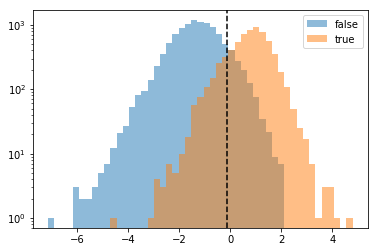

Nuclear membrane 1 0.830558276199804 -0.25655531647176816


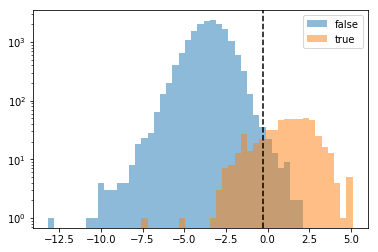

Nucleoli 2 0.7632211538461539 -0.4019469339080183


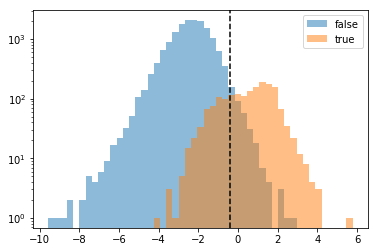

Nucleoli fibrillar center 3 0.7037037037037037 -0.11495286008938585


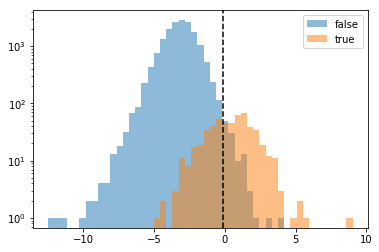

Nuclear speckles 4 0.7774480712166172 -0.4138410797996997


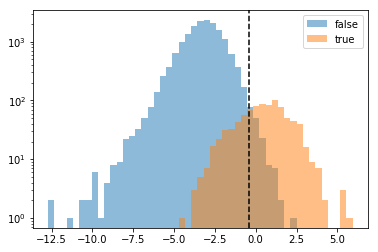

Nuclear bodies 5 0.6497461928934011 -0.15781140496226015


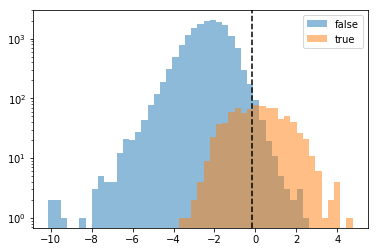

Endoplasmic reticulum 6 0.7156227501799857 -0.21368750094320207


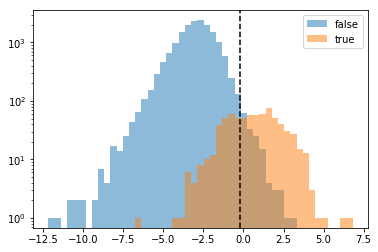

Golgi apparatus 7 0.7540419676642587 -0.0879321060871683


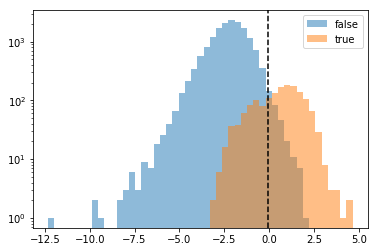

Peroxisomes 8 0.8192771084337349 0.7737742234620406


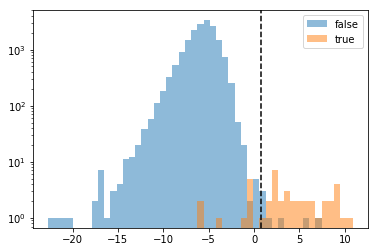

Endosomes 9 0.775 0.0463489172527137


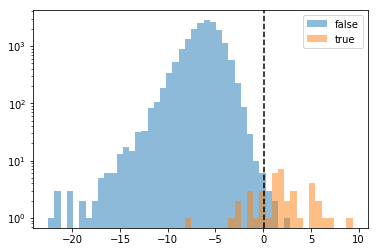

Lysosomes 10 0.782608695652174 0.2954601287566473


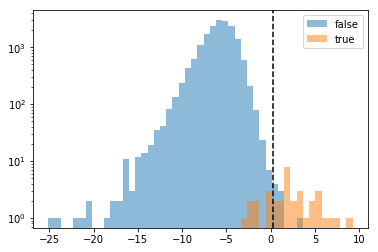

Intermediate filaments 11 0.7343532684283727 -0.45602182648970135


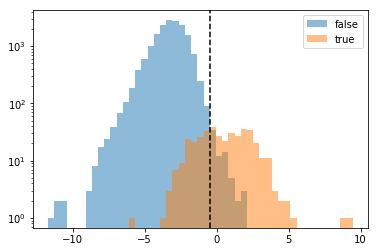

Actin filaments 12 0.6875000000000001 -0.3701900589317164


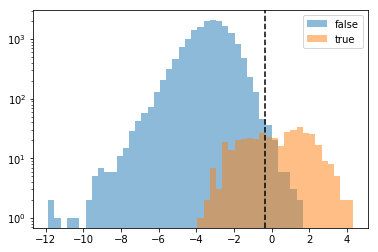

Focal adhesion sites 13 0.6468085106382979 -0.3913640956392734


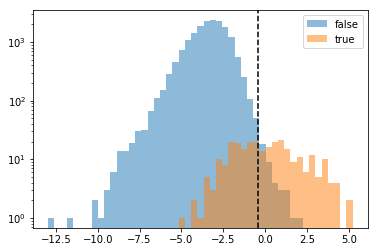

Microtubules 14 0.8495049504950495 -0.36742454909169153


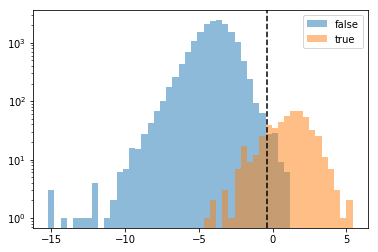

Microtubule ends 15 0.6428571428571429 0.5188663634434545


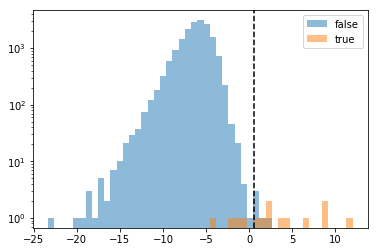

Cytokinetic bridge 16 0.501043841336117 -0.5803568250886595


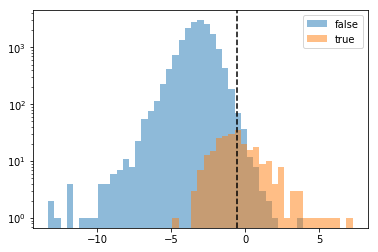

Mitotic spindle 17 0.5578231292517007 -0.26180914531605587


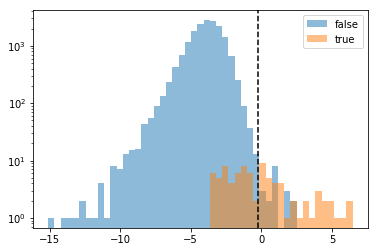

Microtubule organizing center 18 0.5067178502879078 -0.411454229092081


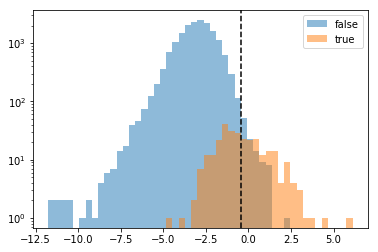

Centrosome 19 0.617075232459848 -0.3887101238003031


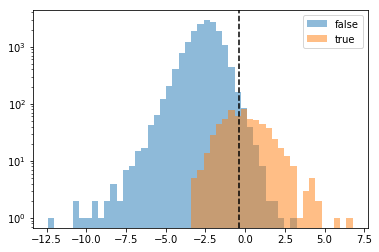

Lipid droplets 20 0.5562913907284769 -0.3131862029732476


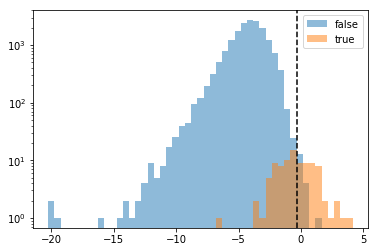

Plasma membrane 21 0.6766413577489951 -0.31044188348503476


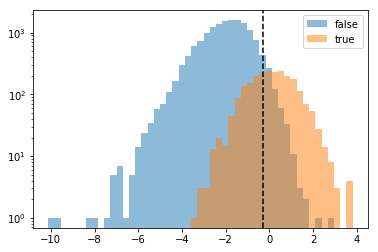

Cell junctions 22 0.5981735159817352 -0.266745217482408


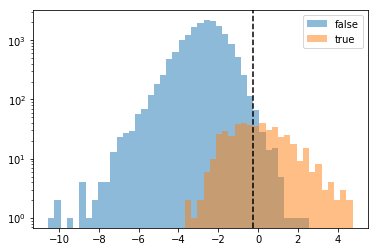

Mitochondria 23 0.842304060434372 -0.23028347774755123


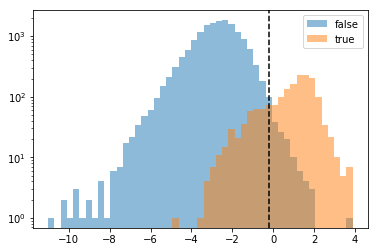

Aggresome 24 0.6 -0.18514346162943465


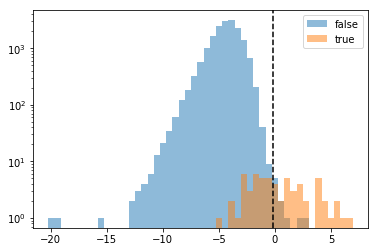

Cytosol 25 0.7848642050656087 -0.13563234365050886


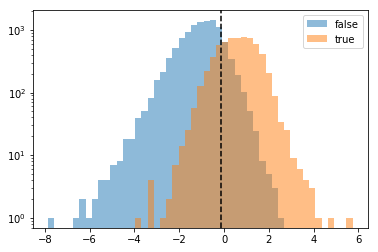

Cytoplasmic bodies 26 0.48076923076923084 -0.35118957965447894


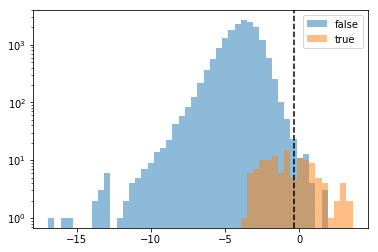

Rods & rings 27 0.6976744186046512 0.612592615993597


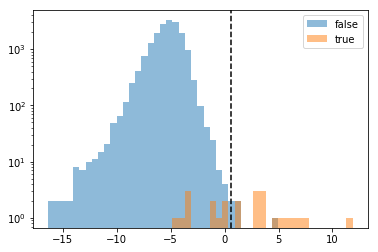

In [32]:
f1 =  sklearn.metrics.f1_score(y, pred>th, average=None)
for i in range(len(name_label_dict)):
    bins = np.linspace(pred[:,i].min(), pred[:,i].max(), 50)
    plt.hist(pred[y[:,i] == 0][:,i], bins, alpha=0.5, log=True, label='false')
    plt.hist(pred[y[:,i] == 1][:,i], bins, alpha=0.5, log=True, label='true')
    plt.legend(loc='upper right')
    print(name_label_dict[i],i, f1[i], th[i])
    plt.axvline(x=th[i], color='k', linestyle='--')
    plt.show()

## Submission

###  Preds for single model

In [33]:
preds_t,y_t = learner.TTA(n_aug=16,is_test=True)
preds_t = np.stack(preds_t, axis=-1)
#preds_t = sigmoid_np(preds_t)
pred_t = preds_t.mean(axis=-1)

 88%|████████▊ | 14/16 [31:02<04:25, 132.95s/it]

KeyboardInterrupt: 

### Ensembling

In [25]:
arch_list = [inception_4, resnet34, resnet50, resnet101]
dict_arch_savedModel = {inception_4:'inception_4_sz512_bs16_fastaiV07', 
                        resnet34:'ResNet34_512_fastaiV07_4thChannel_with_1stChannelWeights_init', 
                        resnet50:'resnet50_sz512_bs16_fastaiV07',
                        resnet101: 'resnet101_sz512_bs16_fastaiV07'}
name = f'{str(list(dict_arch_savedModel.values()))}_ensembled'; name

"['inception_4_sz512_bs16_fastaiV07', 'ResNet34_512_fastaiV07_4thChannel_with_1stChannelWeights_init', 'resnet50_sz512_bs16_fastaiV07', 'resnet101_sz512_bs16_fastaiV07']_ensembled"

In [26]:
predLists_t = []
for arch in arch_list:    
    md = get_data(sz,bs)
    learner = ConvLearner.pretrained(arch, md, ps=0.5) #dropout 50%
    learner.opt_fn = optim.Adam
    learner.clip = 1.0 #gradient clipping
    learner.crit = FocalLoss()
    learner.metrics = [acc]
    learner.load(dict_arch_savedModel[arch])
    preds_t,y_t = learner.TTA(n_aug=16,is_test=True)
    preds_t = np.stack(preds_t, axis=-1)
    #preds_t = sigmoid_np(preds_t)
    pred_t = preds_t.mean(axis=-1)
    predLists_t.append(pred_t)

calculate the prediction average for each image

In [27]:
pred_t_averaged = np.zeros(shape=(len(test_names), len(name_label_dict)))
pred_t_averaged.shape
for i in range(len(test_names)):
    p = np.zeros(len(name_label_dict))
    for pList in predLists_t:
        p += pList[i]
    average = p/len(predLists_t)
    pred_t_averaged[i] = average

pred_t = pred_t_averaged

### Submission files with different thresholds

**It is very important to keep the same order of ids as in the sample submission** https://www.kaggle.com/c/human-protein-atlas-image-classification/discussion/69366#409041 since the competition metric relies only on the order of recods ignoring IDs.

In [ ]:
def save_pred(pred, th=0.0, fname=f'new_{name}.csv'):
    pred_list = []
    for line in pred:
        s = ' '.join(list([str(i) for i in np.nonzero(line>th)[0]]))
        pred_list.append(s)
    
    df = pd.DataFrame({'Id':learner.data.test_ds.fnames,'Predicted':pred_list})
    df.sort_values(by='Id').to_csv(fname, header=True, index=False)

In [ ]:
th_t = np.array([0.565,0.39,0.55,0.345,0.33,0.39,0.33,0.45,0.38,0.39,
               0.34,0.42,0.31,0.38,0.49,0.50,0.38,0.43,0.46,0.40,
               0.39,0.505,0.37,0.47,0.41,0.545,0.32,0.1])
print('Fractions: ',(pred_t > th_t).mean(axis=0))
save_pred(pred_t,th_t)

Automatic fitting the thresholds based on the public LB statistics.

In [ ]:
lb_prob = [
 0.362397820,0.043841336,0.075268817,0.059322034,0.075268817,
 0.075268817,0.043841336,0.075268817,0.010000000,0.010000000,
 0.010000000,0.043841336,0.043841336,0.014198783,0.043841336,
 0.010000000,0.028806584,0.014198783,0.028806584,0.059322034,
 0.010000000,0.126126126,0.028806584,0.075268817,0.010000000,
 0.222493880,0.028806584,0.010000000]
# I replaced 0 by 0.01 since there may be a rounding error leading to 0

In [ ]:
def Count_soft(preds,th=0.0,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    return preds.mean(axis=0)

def fit_test(x,y):
    params = np.zeros(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((Count_soft(x,p) - y,
                                      wd*p), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [ ]:
th_t = fit_test(pred_t,lb_prob)
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
print('Fractions (th = 0.0): ',(pred_t > 0.0).mean(axis=0))

In [ ]:
save_pred(pred_t,th_t,f'new_{name}_f.csv')

Save also predictions for a threshold calculated based on the validation set and constant value 0.5:

In [ ]:
save_pred(pred_t,th,f'new_{name}_v.csv')
save_pred(pred_t,0.0,f'new_{name}_0.csv')

Try using the threshold from validation set for classes not present in the public LB:

In [ ]:
class_list = [8,9,10,15,20,24,27]
for i in class_list:
    th_t[i] = th[i]
save_pred(pred_t,th_t,f'new_{name}_c.csv')

Try fitting thresholds based on the frequency of classes in the train dataset:

In [ ]:
labels = pd.read_csv(LABELS).set_index('Id')
label_count = np.zeros(len(name_label_dict))
for label in labels['Target']:
    l = [int(i) for i in label.split()]
    label_count += np.eye(len(name_label_dict))[l].sum(axis=0)
label_fraction = label_count.astype(np.float)/len(labels)
label_count, label_fraction

In [ ]:
th_t = fit_test(pred_t,label_fraction)
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
save_pred(pred_t,th_t,f'new_{name}_t.csv')

# old

## Validation score

Evaluate the score with using TTA (test time augmentation).

In [ ]:
def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

preds,y = learner.TTA(n_aug=16)
preds = np.stack(preds, axis=-1)
preds = sigmoid_np(preds)
pred = preds.max(axis=-1)

Instead of 0.5, one can adjust the values of the threshold for each class individually to boost the score. The code below does it automatically.

In [ ]:
def F1_soft(preds,targs,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    targs = targs.astype(np.float)
    score = 2.0*(preds*targs).sum(axis=0)/((preds+targs).sum(axis=0) + 1e-6)
    return score

def fit_val(x,y):
    params = 0.5*np.ones(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((F1_soft(x,y,p) - 1.0,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [ ]:
th = fit_val(pred,y)
th[th<0.1] = 0.1
print('Thresholds: ',th)
print('F1 macro: ',sklearn.metrics.f1_score(y, pred>th, average='macro'))
print('F1 macro (th = 0.5): ',sklearn.metrics.f1_score(y, pred>0.5, average='macro'))
print('F1 micro: ',sklearn.metrics.f1_score(y, pred>th, average='micro'))

In [ ]:
print('Fractions: ',(pred > th).mean(axis=0))
print('Fractions (true): ',(y > th).mean(axis=0))

## Submission

### Preds for single model

In [ ]:
preds_t,y_t = learner.TTA(n_aug=16,is_test=True)
preds_t = np.stack(preds_t, axis=-1)
preds_t = sigmoid_np(preds_t)
pred_t = preds_t.max(axis=-1) #max works better for F1 macro score

### Ensembling

In [ ]:
arch_list = [inception_4, resnet34, resnet50, resnet101]
dict_arch_savedModel = {inception_4:'inception_4_sz512_bs16_fastaiV07', 
                        resnet34:'ResNet34_512_fastaiV07_4thChannel_with_1stChannelWeights_init', 
                        resnet50:'resnet50_sz512_bs16_fastaiV07',
                        resnet101: 'resnet101_sz512_bs16_fastaiV07'}
name = f'{str(list(dict_arch_savedModel.values()))}_ensembled'; name

In [ ]:
predLists_t = []
for arch in arch_list:    
    md = get_data(sz,bs)
    learner = ConvLearner.pretrained(arch, md, ps=0.5) #dropout 50%
    learner.opt_fn = optim.Adam
    learner.clip = 1.0 #gradient clipping
    learner.crit = FocalLoss()
    learner.metrics = [acc]
    learner.load(dict_arch_savedModel[arch])
    preds_t,y_t = learner.TTA(n_aug=16,is_test=True)
    preds_t = np.stack(preds_t, axis=-1)
    preds_t = sigmoid_np(preds_t)
    pred_t = preds_t.max(axis=-1)
    predLists_t.append(pred_t)

calculate the prediction average for each image

In [ ]:
pred_t_averaged = np.zeros(shape=(len(test_names), len(name_label_dict)))
pred_t_averaged.shape
for i in range(len(test_names)):
    p = np.zeros(len(name_label_dict))
    for pList in predLists_t:
        p += pList[i]
    average = p/len(predLists_t)
    pred_t_averaged[i] = average

pred_t = pred_t_averaged

### Submission files with different thresholds

It is very important to keep the same order of ids as in the sample submission https://www.kaggle.com/c/human-protein-atlas-image-classification/discussion/69366#409041 since the competition metric relies only on the order of recods ignoring IDs.


In [ ]:
def save_pred(pred, th=0.5, fname=f'old_{name}.csv'):
    pred_list = []
    for line in pred:
        s = ' '.join(list([str(i) for i in np.nonzero(line>th)[0]]))
        pred_list.append(s)
        
    sample_df = pd.read_csv(SAMPLE)
    sample_list = list(sample_df.Id)
    pred_dic = dict((key, value) for (key, value) 
                in zip(learner.data.test_ds.fnames,pred_list))
    pred_list_cor = [pred_dic[id] for id in sample_list]
    df = pd.DataFrame({'Id':sample_list,'Predicted':pred_list_cor})
    df.to_csv(fname, header=True, index=False)

In [ ]:
th_t = np.array([0.565,0.39,0.55,0.345,0.33,0.39,0.33,0.45,0.38,0.39,
               0.34,0.42,0.31,0.38,0.49,0.50,0.38,0.43,0.46,0.40,
               0.39,0.505,0.37,0.47,0.41,0.545,0.32,0.1])
print('Fractions: ',(pred_t > th_t).mean(axis=0))
save_pred(pred_t,th_t)

Automatic fitting the thresholds based on the public LB statistics.


In [ ]:
lb_prob = [
 0.362397820,0.043841336,0.075268817,0.059322034,0.075268817,
 0.075268817,0.043841336,0.075268817,0.010000000,0.010000000,
 0.010000000,0.043841336,0.043841336,0.014198783,0.043841336,
 0.010000000,0.028806584,0.014198783,0.028806584,0.059322034,
 0.010000000,0.126126126,0.028806584,0.075268817,0.010000000,
 0.222493880,0.028806584,0.010000000]
# I replaced 0 by 0.01 since there may be a rounding error leading to 0

In [ ]:
def Count_soft(preds,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    return preds.mean(axis=0)

def fit_test(x,y):
    params = 0.5*np.ones(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((Count_soft(x,p) - y,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [ ]:
th_t = fit_test(pred_t,lb_prob)
th_t[th_t<0.1] = 0.1
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
print('Fractions (th = 0.5): ',(pred_t > 0.5).mean(axis=0))

In [ ]:
save_pred(pred_t,th_t, f'old_{name}_f.csv')

In [ ]:
save_pred(pred_t,th,f'old_{name}_v.csv')
save_pred(pred_t,0.5,f'old_{name}_05.csv')

In [ ]:
class_list = [8,9,10,15,20,24,27]
for i in class_list:
    th_t[i] = th[i]
save_pred(pred_t,th_t,f'old_{name}_c.csv')

In [ ]:
labels = pd.read_csv(LABELS).set_index('Id')
label_count = np.zeros(len(name_label_dict))
for label in labels['Target']:
    l = [int(i) for i in label.split()]
    label_count += np.eye(len(name_label_dict))[l].sum(axis=0)
label_fraction = label_count.astype(np.float)/len(labels)
label_count, label_fraction

In [ ]:
th_t = fit_test(pred_t,label_fraction)
th_t[th_t<0.05] = 0.05
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
save_pred(pred_t,th_t,f'old_{name}_t.csv')